In [1]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers.legacy import Adam


class Stock:
    def __init__(self, symbol, initial_price, initial_quantity):
        self.symbol = symbol
        self.price = initial_price
        self.quantity = initial_quantity
        self.price_history = [initial_price]  # 记录每天的股票价格

    def fluctuate(self):
        # 控制股价波动在-10%到10%之间
        change_percentage = random.uniform(-0.1, 0.1)
        self.price *= (1 + change_percentage)
        self.price = round(self.price, 3)  # 保留小数点后三位
        self.price_history.append(self.price)
        

class Trader:
    def __init__(self, name, strategy, initial_funds, initial_quantity):
        self.name = name
        self.strategy = strategy
        self.funds = initial_funds
        self.quantity = initial_quantity
        self.total_assets = initial_funds + initial_quantity * stock.price
        self.funds_history = [round(initial_funds, 3)]
        self.quantity_history = [initial_quantity]
        self.total_assets_history = [round(self.total_assets, 3)]
    
    def get_state(self, stock):
        return np.array([[stock.price, self.funds, self.quantity]])

    def execute_action(self, action, stock):
        if action == 0:  # buy
            if self.funds >= stock.price:
                buy_quantity = min(stock.quantity, int(self.funds / stock.price))
                self.funds -= buy_quantity * stock.price
                self.quantity += buy_quantity
                stock.quantity -= buy_quantity
        elif action == 1:  # sell
            if self.quantity > 0:
                sell_quantity = min(self.quantity, stock.quantity)
                self.funds += sell_quantity * stock.price
                self.quantity -= sell_quantity
                stock.quantity += sell_quantity
        # calculate new total assets
        self.total_assets = self.funds + self.quantity * stock.price

    def get_reward(self):
        return self.total_assets


In [2]:
# 创建股票
initial_quantity = 100000
stock = Stock("AAPL", 100, initial_quantity)

# 初始资金
initial_funds = 1000000  # 100万

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


episode: 0/10, total assets: 996408.64, epsilon: 1.00
episode: 1/10, total assets: 688586.50, epsilon: 1.00
1/1 [==============================] - 0s 7ms/step


/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 7ms/step
episode: 2/10, total assets: 697111.35, epsilon: 0.99
1/1 [==============================] - 0s 7ms/step
episode: 3/10, total assets: 868779.94, epsilon: 0.99
1/1 [==============================] - 0s 7ms/step
episode: 4/10, total assets: 931079.95, epsilon: 0.99
1/1 [==============================] - 0s 7ms/step
episode: 5/10, total assets: 826486.44, epsilon: 0.98
1/1 [==============================] - 0s 7ms/step
episode: 6/10, total assets: 850809.65, epsilon: 0.98
1/1 [==============================] - 0s 7ms/step
episode: 7/10, total assets: 977781.36, epsilon: 0.97
1/1 [==============================] - 0s 7ms/step
episode: 8/10, total assets: 1033403.98, epsilon: 0.97
1/1 [==============================] - 0s 7ms/step
episode: 9/10, total assets: 1135438.93, epsilon: 0.96
1/1 [==============================] - 0s 7ms/step


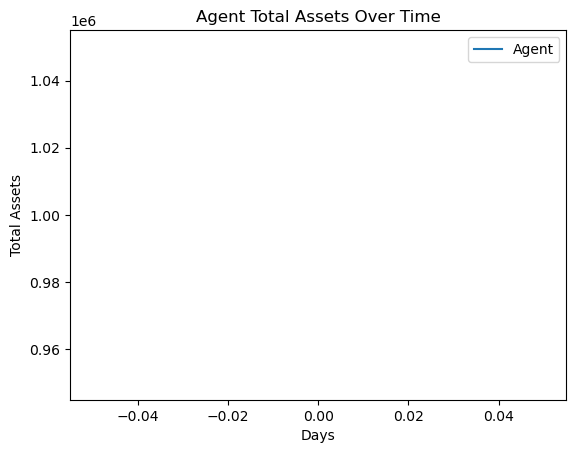

In [4]:
state_size = 3  # [price, funds, quantity]
action_size = 3  # [buy, sell, hold]
agent = DQNAgent(state_size, action_size)
batch_size = 32
episodes = 10

for e in range(episodes):
    stock = Stock("AAPL", 100, initial_quantity)
    trader = Trader("Agent", None, initial_funds, 0)

    for day in range(1, 31):
        state = trader.get_state(stock)
        action = agent.act(state)
        trader.execute_action(action, stock)
        next_state = trader.get_state(stock)
        reward = trader.get_reward()
        done = day == 30
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{episodes}, total assets: {trader.total_assets:.2f}, epsilon: {agent.epsilon:.2f}")
            break
        stock.fluctuate()
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)


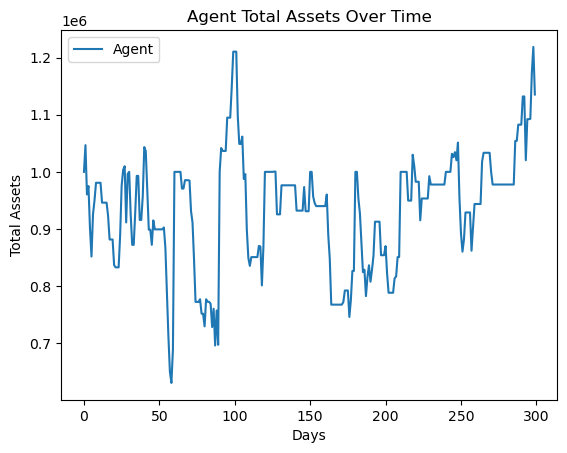

In [13]:
# 可视化代理的总资产
plt.plot(asset, label='Agent')
plt.xlabel('Days')
plt.ylabel('Total Assets')
plt.title('Agent Total Assets Over Time')
plt.legend()
plt.show()

In [11]:
asset = []
for i in agent.memory:
    asset.append(i[2])

In [14]:
asset

[1000000,
 1046790.0,
 960450.0,
 975050.0,
 901100.0,
 851740.0000000001,
 925560.0,
 949980.0,
 980860.0,
 980860.0,
 980860.0,
 980860.0,
 946091.891,
 946091.891,
 946091.891,
 946091.891,
 923164.7559999999,
 881584.7109999999,
 881584.7109999999,
 881584.7109999999,
 836724.298,
 832741.0719999999,
 832741.0719999999,
 832741.0719999999,
 889061.254,
 975912.9979999999,
 1003378.78,
 1009880.0369999999,
 911468.499,
 996408.639,
 1000000,
 924629.9999999999,
 872230.0,
 872230.0,
 928437.34,
 992925.4,
 992925.4,
 915806.3680000001,
 915806.3680000001,
 957428.7440000001,
 1043433.5750000001,
 1036009.251,
 968219.0180000002,
 898736.1930000001,
 898736.1930000001,
 872200.1730000001,
 915021.8030000001,
 899301.993,
 899301.993,
 899301.993,
 899301.993,
 899301.993,
 899301.993,
 902663.6770000001,
 866991.285,
 791053.627,
 712043.3470000001,
 649852.1930000001,
 630399.3910000001,
 688586.501,
 1000000,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0,
 970699.441,
 970699.441,